# Virulence Classifier 

This notebook allows the construction, training and evaluation of the virulence classifier. 

## **Import Necessary Modules**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install biopython

     |████████████████████████████████| 2.3 MB 5.2 MB/s 


In [ ]:
import os
import keras
import numpy as np
from Bio import SeqIO  
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Embedding, LSTM
from keras import regularizers, layers, preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from Bio.Seq import Seq
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## **CNN architecture and data preprocessing**
Credit to: https://www.kaggle.com/drscarlat/predict-antibiotic-resistance-w-gene-sequence/

In [ ]:
def cnn():
  model = Sequential()
  model.add(Embedding(64, 2, input_length=maxlen))
  model.add(layers.Conv1D(128, 243, activation='relu'))
  model.add(layers.MaxPooling1D(3))
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, 81, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, 27, activation='relu'))
  model.add(layers.MaxPooling1D(3))
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, 9, activation='relu'))
  model.add(layers.MaxPooling1D(3))
  model.add(layers.Dropout(0.5))
  model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2, recurrent_dropout=0.5)))
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  model.summary()
  return(model)

In [ ]:
Dataframe = pd.read_csv('ADD_YOUR_PATH_HERE!') #Reading the generated CSV. Add the path of your CSV here.
Dataframe = shuffle(Dataframe) #The shuffle is necessary to ensure that all antibiotic types are included in the test set afterwards

#Process of conversion from aminoacid sequence to codon sequence
Datacodons = Dataframe.copy()

Codons = list(Datacodons['genes'])

length = []
for n in range(len(Codons)):
    Codons[n] = list([Codons[n][i:i+3] for i in range(0, len(Codons[n]), 3)])
    length.append(len(Codons[n]))
    
Datacodons['codons'] = Codons

#The maximum length will be used for the padding of sequences
maxlen = max(length) 

max_words = 64 # Number of words in the dictionary, equal to the number of  possible codons
max_features = max_words

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(Datacodons['codons']))
sequences = tokenizer.texts_to_sequences(list(Datacodons['codons']))
word_index = tokenizer.word_index
Pad_input = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)

# This step ensures that the generated dictionary has exactly what we asked for since in some cases words that are not codons are generated
new_dict= {'cac', 'cgt', 'aat', 'atg', 'tac', 'att', 'tgg', 'gac', 'tgc', 'act', 'gtt', 'gaa', 'aaa', 'cag', 'tga', 'ttg', 'gct', 'ttc', 'tct', 'ggc', 'aca', 'taa', 'ctg', 'ata', 'caa', 'ctt', 'tcg', 'gtc', 'aac', 'gga', 'acg', 'gca', 'tta', 'cta', 'acc', 'gat', 'tca', 'tat', 'agg', 'tgt', 'gtg', 'cga', 'cgc', 'ttt', 'aga', 'ggt', 'ctc', 'cca', 'ccg', 'gcg', 'a', 'ga', 'tag', 'atc', 'cat', 'agt', 'cgg', 'aag', 'gag', 'cct', 'gta', 'ggg', 'tcc', 'agc', 'ccc', 'gcc'}
unwanted= set(word_index) - set(new_dict)
for unwanted_key in unwanted: del word_index[unwanted_key]

labels = np.asarray(Datacodons['class'])

training_samples = int(Pad_input.shape[0] * 0.8) # This number will be used to separate between train set (80% of data) and test set (20% of data)


indices = np.arange(Pad_input.shape[0])

Xpad = Pad_input[indices]
labels = labels[indices]


x_train = np.asarray(Pad_input[:training_samples])
y_train = np.asarray(labels[:training_samples])
x_test = np.asarray(Pad_input[training_samples:])
y_test = np.asarray(labels[training_samples:])

encoder=LabelEncoder()
encoder.fit(y_train)
encoded_Y=encoder.transform(y_train)

encoder1=LabelEncoder()
encoder1.fit(y_test)
encoded_Y1=encoder1.transform(y_test)
y=np_utils.to_categorical(encoded_Y)
y_test=np_utils.to_categorical(encoded_Y1)


model = cnn()

## Fit and save the model

In [ ]:
gym = model.fit(x_train, y_train, epochs = 15, batch_size=16, validation_split=0.2)

In [ ]:
model.save('ADD_YOUR_PATH_HERE!') # Indicate the path where the model will be saved

## Metrics calculation and first prediction, individual labels

With this cell you can input the path of the saved model and look at the confusion matrix and classification report for resistance mechanisms only. This will display a total of 9 matrices.

Credit for the function for plotting the matrix in a beatiful manner and the probability treshold decision to: https://www.kaggle.com/drscarlat/predict-antibiotic-resistance-w-gene-sequence/

11/11 [==============================] - 55s 5s/step - loss: 0.5198 - acc: 0.8064
Metrics Report: 
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       178
           1       0.87      0.71      0.78       168

   micro avg       0.81      0.81      0.81       346
   macro avg       0.82      0.80      0.80       346
weighted avg       0.82      0.81      0.80       346
 samples avg       0.81      0.81      0.81       346



<Figure size 432x288 with 0 Axes>

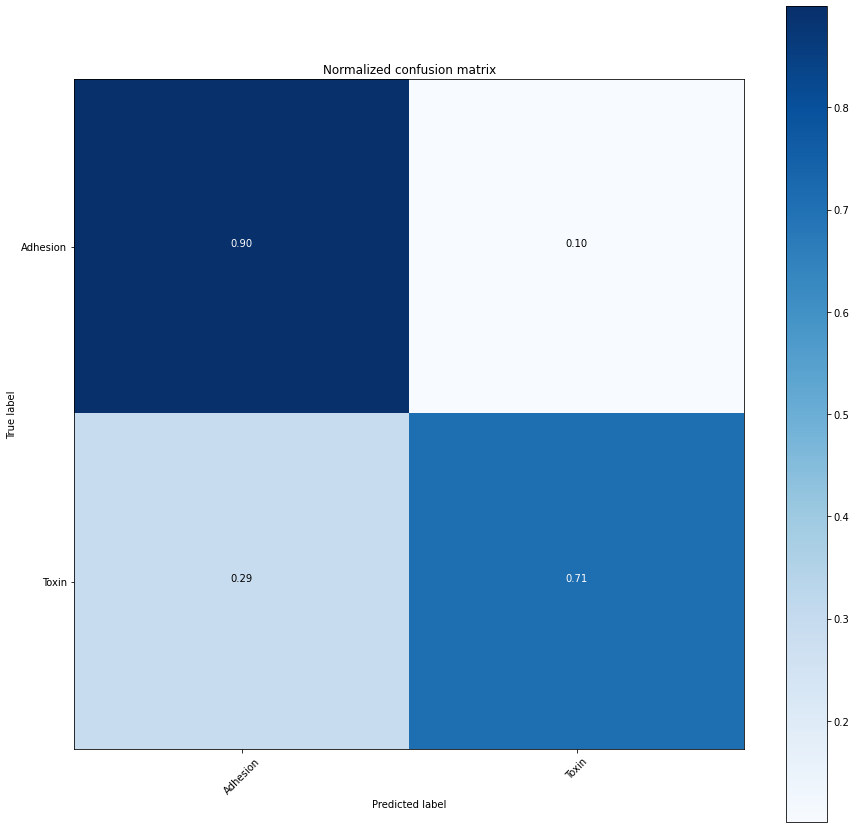

In [ ]:
model = keras.models.load_model('ADD_YOUR_PATH_HERE!')  # Add the path where the model has been saved

def separate_metrics(matrix,cyst):
  TP=matrix[cyst][cyst]
  FN=sum(matrix[cyst,:])-TP
  FP=sum(matrix[:,cyst])-TP
  TN=sum(sum(matrix))-TP-FP-FN
  return TP,FP,TN,FN
  
final_predictions = model.predict(x_test)  # We use keras to predict the mechanisms of the test set, the predicitons are arrays of 2 positions with the probability to belong to each label
evaluate=model.evaluate(x_test,y_test) # We can obtain the metrics for accuracy in the test set in a direct manner by putting the labels
# Important! Transform the probabilities to binary decisions (either you belong to a label or not), we used the typical treshold in literature of 0.5
Preds = final_predictions.copy()
Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0

#Since both the predictions and the labels are in binary format, we can use SKLearn to plot a report of metrics for our predicitons
print('Metrics Report: ')
report = classification_report(y_test, Preds)
print(report)

y_pred = [np.argmax(output) for output in final_predictions]
y_test_int = np.argmax(y_test, axis=1)

class_names = ['Adhesion','Toxin']

#Function to plot a generated confusion matrix from Alexander Scarlat, you can select the colormap, light or dark theme and the figure size
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
    
# we compute the confusion matrix
cnf_matrix = confusion_matrix(y_test_int, y_pred)
np.set_printoptions(precision=2)

# we plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()